<a href="https://colab.research.google.com/github/benihime91/retinanet_pet_detector/blob/master/resnet50_backbone.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Ensure colab doesn't disconnect
%%javascript
function ClickConnect(){
console.log("Working");
document.querySelector("colab-toolbar-button#connect").click()
}setInterval(ClickConnect,60000)

In [1]:
# what GPU do we have ?
! nvidia-smi

Sat Sep 19 21:27:02 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 450.66       Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   55C    P8    11W /  70W |      0MiB / 15079MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

**Setup Google-Colab:**

In [ ]:
# install dependencies
!pip install pytorch-lightning omegaconf --quiet
!pip install git+https://github.com/albumentations-team/albumentations --quiet

In [ ]:
# Run this cell to mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
# clone the github repo:
!git clone --recurse-submodules -j8 https://github.com/benihime91/retinanet_pet_detector.git

**Untar the data from Google Drive and save it to VM memory :**

- The cell below unzips the data assuming the `The Oxford-IIIT Pet Dataset` is present in `/content/drive/My Drive/Data/oxford-iiit-pet.tgz.`

- If data is not downloaded download the data from [here](https://www.robots.ox.ac.uk/~vgg/data/pets) and save in it in Google Drive under `Data/oxford-iiit-pet.tgz`.

In [6]:
!tar xf /content/drive/My\ Drive/Data/oxford-iiit-pet.tgz -C /content/

**Imports:**

In [7]:
import sys
import os
import warnings

os.chdir("/content/retinanet_pet_detector")
warnings.filterwarnings("ignore")
%matplotlib inline
%load_ext tensorboard

In [8]:
# Standard Imports
import numpy as np
from omegaconf import OmegaConf
import pandas as pd
import argparse


from train import main
from references.data_utils import _get_logger
from references import Visualizer
from references.utils import get_label_dict

# Set up logging
logger = _get_logger()
pd.set_option("display.max_colwidth",None)

**Preprare Data:**

Before training we need to convert the data into a format that is compatible with the `training pipeline.` We will use `references/data_utils.py` to convert all the xml annotation files into a csv that stores all the annotations and path to the Images.

The resutant csv file will be saved as `/{ouptut_dir}/data-full.csv`.

In [9]:
# Convert xml files to a csv file
!python references/data_utils.py \
    --action create \
    --img_dir "/content/oxford-iiit-pet/images" \
    --annot_dir "/content/oxford-iiit-pet/annotations/xmls" \
    --labels "/content/retinanet_pet_detector/data/labels.names" \
    --output_dir "/content/retinanet_pet_detector/data/"

[09/19 21:28:56 data_utils]: Converting xml files to a csv file
[09/19 21:28:56 data_utils]: Image Directory: /content/oxford-iiit-pet/images
[09/19 21:28:56 data_utils]: Annotation Directory: /content/oxford-iiit-pet/annotations/xmls
[09/19 21:28:56 data_utils]: Path to labels: /content/retinanet_pet_detector/data/labels.names
[09/19 21:28:57 data_utils]: Number of unique classes found: 37
[09/19 21:28:57 data_utils]: csv file saved as /content/retinanet_pet_detector/data/data-full.csv


This is what our data looks like:

In [10]:
df = pd.read_csv("/content/retinanet_pet_detector/data/data-full.csv")
df.head(5)

,filename,width,height,xmin,ymin,xmax,ymax,classes,labels
0,/content/oxford-iiit-pet/images/german_shorthaired_125.jpg,500,375,157,56,264,116,german_shorthaired,14
1,/content/oxford-iiit-pet/images/german_shorthaired_128.jpg,453,500,248,39,388,158,german_shorthaired,14
2,/content/oxford-iiit-pet/images/english_setter_178.jpg,365,500,19,13,275,270,english_setter,13
3,/content/oxford-iiit-pet/images/leonberger_107.jpg,333,500,92,145,193,248,leonberger,19
4,/content/oxford-iiit-pet/images/saint_bernard_165.jpg,500,375,164,76,362,232,saint_bernard,28


We will again the run the script used above but this time we will run this script to create `training`, `validation` & `test` sets from the full dataset.

In [11]:
# Create train, validaiton and test splits in the data
!python references/data_utils.py \
    --action split \
    --csv "/content/retinanet_pet_detector/data/data-full.csv"\
    --valid_size 0.3 \
    --test_size 0.5 \
    --output_dir "/content/retinanet_pet_detector/data/"

[09/19 21:29:03 data_utils]: path to the given csv file : /content/retinanet_pet_detector/data/data-full.csv
[09/19 21:29:03 data_utils]: Creating train, validation and test splits
[09/19 21:29:05 data_utils]: Number of training examples=2580
[09/19 21:29:05 data_utils]: Number of validation examples=1843
[09/19 21:29:05 data_utils]: Number of test examples=1843
[09/19 21:29:05 data_utils]: Files saved to /content/retinanet_pet_detector/data/


We can see that now we have 3 extra files train.csv, valid.csv & test.csv. This files correspond to the `train`,`validation` & `test` datasets respectively.

In [12]:
! ls "/content/retinanet_pet_detector/data"

data-full.csv  labels.names  test.csv  train.csv  valid.csv


In [13]:
# Read in the train and test dataframes
trn_df = pd.read_csv("/content/retinanet_pet_detector/data/train.csv")
tst_df = pd.read_csv("/content/retinanet_pet_detector/data/test.csv")

In [14]:
trn_df.head()

,filename,width,height,xmin,ymin,xmax,ymax,classes,labels
0,/content/oxford-iiit-pet/images/german_shorthaired_128.jpg,453,500,248,39,388,158,german_shorthaired,14
1,/content/oxford-iiit-pet/images/english_setter_178.jpg,365,500,19,13,275,270,english_setter,13
2,/content/oxford-iiit-pet/images/leonberger_107.jpg,333,500,92,145,193,248,leonberger,19
3,/content/oxford-iiit-pet/images/saint_bernard_165.jpg,500,375,164,76,362,232,saint_bernard,28
4,/content/oxford-iiit-pet/images/shiba_inu_189.jpg,375,500,139,20,336,242,shiba_inu,31


In [15]:
tst_df.head()

,filename,width,height,xmin,ymin,xmax,ymax,classes,labels
0,/content/oxford-iiit-pet/images/german_shorthaired_128.jpg,453,500,248,39,388,158,german_shorthaired,14
1,/content/oxford-iiit-pet/images/english_setter_178.jpg,365,500,19,13,275,270,english_setter,13
2,/content/oxford-iiit-pet/images/leonberger_107.jpg,333,500,92,145,193,248,leonberger,19
3,/content/oxford-iiit-pet/images/saint_bernard_165.jpg,500,375,164,76,362,232,saint_bernard,28
4,/content/oxford-iiit-pet/images/shiba_inu_189.jpg,375,500,139,20,336,242,shiba_inu,31


**View some images from the datasets:**

In [16]:
# Read in the Labes dictionary 
# and initializer the visualizer to view images with bboxes
label_dict = get_label_dict("/content/retinanet_pet_detector/data/labels.names")
vis = Visualizer(label_dict)

[09/19 21:29:18 references.display_preds]: visualizer initialized


In [17]:
np.random.seed(123)

def display_random_image(data):
    """
    Fn to display a random using the `Visualizer`
    from the given pandas dataframe. The bounding boxes are also
    drawn over the image.

    Args:
     data (`pd.dataframe`): A `pandas dataframe` where filename corresponds to 
                            the image path and bbox co-ordinates are stored in 
                            `[xmin,xmax,ymin,ymax]` & class_names (`int`) are 
                            stored in `[labels]`.
    """
    idx = np.random.randint(0, len(df))
    image_id = df.filename[idx]
    locs = df.loc[df.filename == image_id]
    boxes = locs[['xmin','ymin','xmax','ymax']].values
    labels = locs['labels'].values
    vis.draw_bboxes(image_id, boxes, labels)

[09/19 21:29:23 references.display_preds]: Found 1 bounding box(s) on the given image
[09/19 21:29:23 references.display_preds]: Displaying Results ....


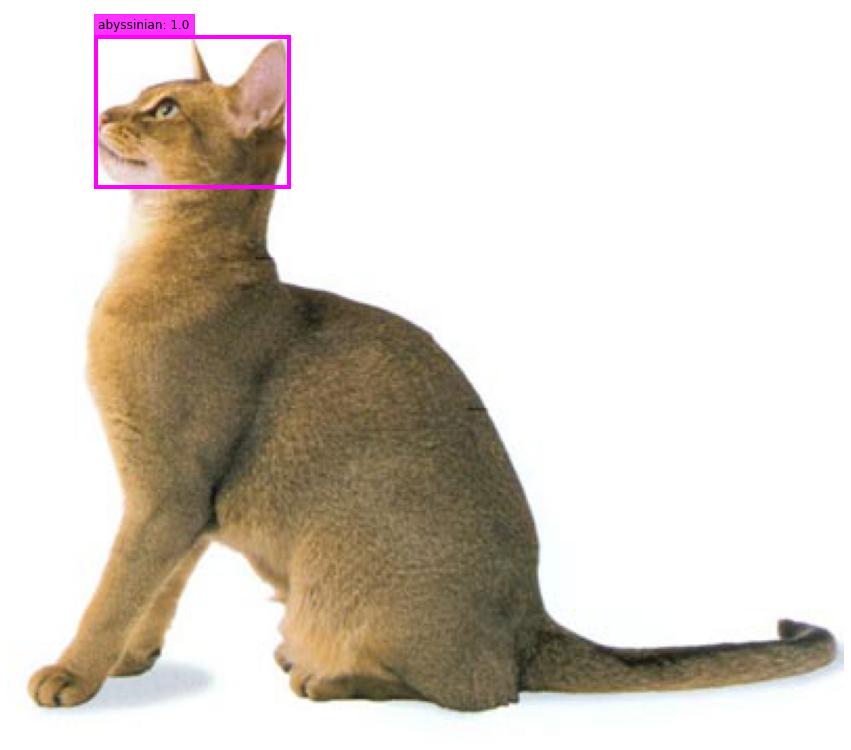

In [18]:
# Display a random Image from the Train dataset
display_random_image(data=trn_df)

[09/19 21:29:24 references.display_preds]: Found 1 bounding box(s) on the given image
[09/19 21:29:24 references.display_preds]: Displaying Results ....


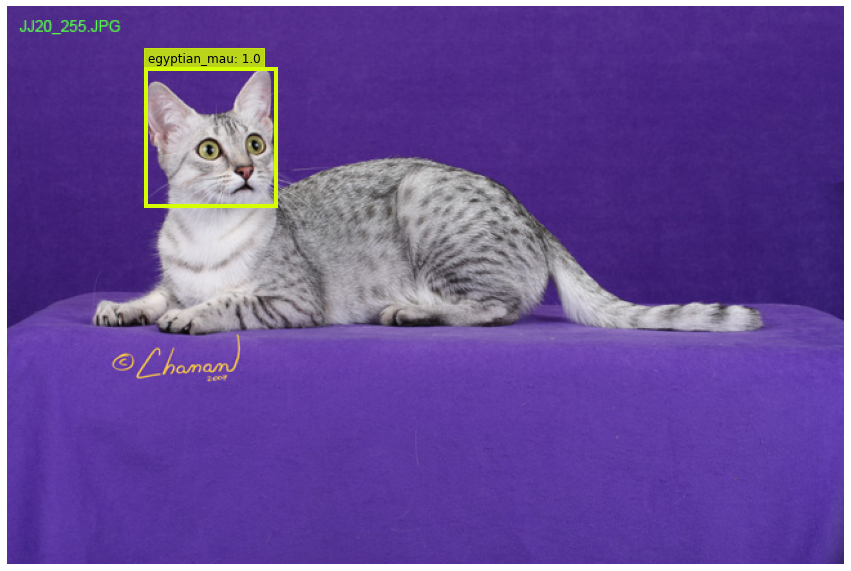

In [19]:
# Display a random Image from the test dataset
display_random_image(data=tst_df)

**Load (or Modify) the Config file:**

In [20]:
# load the config file
config = OmegaConf.load("/content/retinanet_pet_detector/main.yaml")

# -------------------------------------------- #
# Modify some config parameters:
# -------------------------------------------- #

# since we will use the resnet50 backbone retinanet to train model
config.model.backbone_kind = "resnet50" 
# update the paths to the train, validation and test csv files
config.hparams.train_csv = "/content/retinanet_pet_detector/data/train.csv"
config.hparams.valid_csv = "/content/retinanet_pet_detector/data/valid.csv"
config.hparams.test_csv  = "/content/retinanet_pet_detector/data/test.csv"
# update the batch size for the train dataset
config.hparams.train_batch_size = 4
# maximum epoch to train for
config.trainer.flags.max_epochs = 55
# path to where checkpoint and final weights are saved
config.trainer.model_checkpoint.params.filepath = "/content/drive/My Drive/retianet-pets"
# path to where the training logs are saved for TensorBoard Logger
config.trainer.logger.params.save_dir = "/content/logs/"
# Check results on validaiton dataset every 5 epochs
config.trainer.flags.check_val_every_n_epoch = 5
# modify Optimizer & Scheduler parameters
config.hparams.optimizer.params.lr = 0.02
config.hparams.optimizer.params.weight_decay = 0.001
config.hparams.scheduler.params.milestones = [28,42]



# Save the modified config file
OmegaConf.save(config=config, f="/content/retinanet_pet_detector/main.yaml")

In [21]:
# view config 
logger.info(f"\nConfiguration File:  \n{OmegaConf.to_yaml(config)}")

[09/19 21:29:36 references.data_utils]: 
Configuration File:  
model:
  backbone_kind: resnet50
  num_classes: 37
  freeze_bn: true
  min_size: 800
  max_size: 800
hparams:
  train_csv: /content/retinanet_pet_detector/data/train.csv
  train_batch_size: 4
  valid_csv: /content/retinanet_pet_detector/data/valid.csv
  valid_batch_size: 32
  test_csv: /content/retinanet_pet_detector/data/test.csv
  test_batch_size: 32
  iou_types: bbox
  optimizer:
    class_name: torch.optim.SGD
    params:
      lr: 0.02
      weight_decay: 0.001
      momentum: 0.9
  scheduler:
    class_name: torch.optim.lr_scheduler.MultiStepLR
    params:
      milestones:
      - 28
      - 42
      gamma: 0.1
    interval: epoch
    frequency: 1
  augmentation:
    train:
    - class_name: albumentations.HorizontalFlip
      params:
        p: 0.5
    - class_name: albumentations.ToGray
      params:
        p: 0.25
    - class_name: albumentations.CLAHE
      params:
        p: 0.5
    - class_name: albumentations

### **Train, Validation & Test :**

In colab use the main function to train otherwise Lightning progress bar goes mad, this issue is highlighted [here]( https://github.com/PyTorchLightning/pytorch-lightning/issues/721). 

The `main` function accepts `argparse` arguments so we will first define a `Dictionary` with the args and convert it to `argparse.Namespace` instance

In [22]:
# Creat argument dictionary
d = {"config": "/content/retinanet_pet_detector/main.yaml", "verbose": 0}
args = argparse.Namespace(**d)

logger.info(f"Namespace Arguments:  {args}")

[09/19 21:29:43 references.data_utils]: Namespace Arguments:  Namespace(config='/content/retinanet_pet_detector/main.yaml', verbose=0)


**Start Train :**

In [ ]:
# run the main function
# set a seed number to ensure results are reproducible
main(args, seed=123)

[09/19 21:29:49 Lightning]: Random seed = 123


Downloading: "https://download.pytorch.org/models/resnet50-19c8e357.pth" to /root/.cache/torch/hub/checkpoints/resnet50-19c8e357.pth



[09/19 21:29:51 pytorch_retinanet.retinanet.models]: Backbone : resnet50
[09/19 21:29:51 pytorch_retinanet.retinanet.models]: Score Threshold : 0.05
[09/19 21:29:51 pytorch_retinanet.retinanet.models]: NMS Threshold : 0.5
[09/19 21:29:51 pytorch_retinanet.retinanet.models]: Num Classes : 37
[09/19 21:29:51 pytorch_retinanet.retinanet.models]: Image Resize parameters: smallest_image_size=800
[09/19 21:29:51 pytorch_retinanet.retinanet.models]: Image Resize parameters: maximum_image_size=800


GPU available: True, used: True
[09/19 21:29:51] lightning INFO: GPU available: True, used: True
TPU available: False, using: 0 TPU cores
[09/19 21:29:51] lightning INFO: TPU available: False, using: 0 TPU cores
CUDA_VISIBLE_DEVICES: [0]
[09/19 21:29:51] lightning INFO: CUDA_VISIBLE_DEVICES: [0]
Using native 16bit precision.
[09/19 21:29:51] lightning INFO: Using native 16bit precision.


[09/19 21:29:51 references.lightning]: Augmentations used in training: [HorizontalFlip(always_apply=False, p=0.5), ToGray(always_apply=False, p=0.25), CLAHE(always_apply=False, p=0.5, clip_limit=(1, 4.0), tile_grid_size=(8, 8)), ToFloat(always_apply=True, p=1.0, max_value=255.0), ToTensorV2(always_apply=True, p=1.0)]
[09/19 21:29:51 references.lightning]: Serialized train dataset from /content/retinanet_pet_detector/data/train.csv
[09/19 21:29:51 references.lightning]: Serialized dataset takes 0.22 MiB
[09/19 21:29:51 references.lightning]: Serialized validation dataset from /content/retinanet_pet_detector/data/valid.csv
[09/19 21:29:51 references.lightning]: Serialized dataset takes 0.16 MiB
[09/19 21:29:51 references.lightning]: Serialized test dataset from /content/retinanet_pet_detector/data/test.csv
[09/19 21:29:51 references.lightning]: Serialized dataset takes 0.16 MiB


## **Inference with saved weights:**

To do inference we need to modify or create a config file for inference. An example config file is present in `/content/retinanet_pet_detector/config/resnet34.yaml`. The config file for inference should contain the following:

- `model_backbone` (`str`) : resnet backbone used for the retinanet model.
- `url` (`str`) : url or the path to where weights are saved.
- `num_classes` (`int`) : total number of unique classes

In [ ]:
from omegaconf import DictConfig
from IPython.display import Image
from google.colab import files

In [ ]:
# Since we used a resnet-50 backbone for our retinanet model
# we will load in the config for the resnet-34 model
# and update the url to be the trainerd weights.
backbone = "resnet50"
# path to where model weights are saved
url = "/content/drive/My Drive/retianet-pets/weights.pth"
# total number of classes
num_classes = 37

d = {
    "model_backbone": backbone,
    "url": url,
    "num_classes": num_classes
}
conf = DictConfig(d)

# Save the modified config File
fname = "/content/retinanet_pet_detector/config/resnet50.yaml"
OmegaConf.save(config=conf, f=fname)


# Print out the config File
print(OmegaConf.to_yaml(conf))

In [ ]:
# path to the ocnfig file
config = "/content/retinanet_pet_detector/config/resnet50.yaml"

**Run Inference:**

In [ ]:
!python inference.py \
    --config {config} \
    --image "/content/oxford-iiit-pet/images/english_cocker_spaniel_120.jpg"\
    --score_thres 0.7 \
    --iou_thres 0.4 \
    --save_dir "/content/" \
    --fname "res_1.png" \

In [ ]:
Image("/content/res_1.png")

In [ ]:
!python inference.py \
    --config {config} \
    --image "/content/oxford-iiit-pet/images/Ragdoll_142.jpg"\
    --score_thres 0.7 \
    --iou_thres 0.4 \
    --save_dir "/content/" \
    --fname "res_2.png" \

In [ ]:
Image("/content/res_2.png")

**The following cells run inference on user uploaded image:**

In [ ]:
uploaded = files.upload()
fname = list(uploaded.keys())[0]

In [ ]:
!python inference.py \
    --config {config}\
    --image {fname} \
    --score_thres 0.7 \
    --iou_thres 0.4 \
    --save_dir "/content/" \
    --fname "res_3.png" \

In [ ]:
Image("/content/res_3.png")